<a href="https://colab.research.google.com/github/dtminnick/pytorch-practice/blob/main/dl_assignment1_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manually Graded Assignment 1 - Part 2: CNN with the CIFAR Dataset

Donnie Minnick - Deep Learning - Fall B 2025 - October 2025

# Introduction and Objective

This notebook explores image classification using Convolutional Neural Networks (CNNs) on the CIFAR-10 dataset, a benchmark collection of 60,000 32×32 color images across 10 object categories. CNNs are well-suited for visual recognition tasks due to their ability to hierarchically extract spatial features.

The goal is to build a modular CNN architecture, evaluate its performance, and iteratively tune hyperparameters such as kernel size, stride, and batch size to optimize classification accuracy. All experiments are scaffolded for reproducibility and interpretability, with annotated logging and visual diagnostics to support stakeholder clarity.

Objectives include:

* Load and preprocess the CIFAR-10 dataset using PyTorch and torchvision transforms.
* Design and implement a CNN with convolutional layers tailored for image classification.
* Train the model and report classification accuracy on the test set.
* Perform hyperparameter tuning to improve model performance, focusing on kernel size, stride, and batch size.
* Log training dynamics and visualize feature map evolution to support interpretability and stakeholder reporting.

# Import Libraries

My toolkit is modular and purposeful: PyTorch powers the neural architecture and training loop, while torchvision streamlines dataset loading and image transformations. We augment the data with horizontal flips and random crops to simulate real-world variability, then normalize it for stable training dynamics.

Each import serves a role in our interpretability-first workflow:

**Modeling & Optimization**: torch.nn, torch.optim, and F scaffold the CNN layers and training logic.

**Data Management**: DataLoader and random_split orchestrate reproducible batching and validation splits.

**Visualization**: make_grid, to_pil_image, and matplotlib help us inspect feature maps and training curves.

**Diagnostics**: confusion_matrix, numpy, and pandas surface performance bottlenecks and class-level insights.

My objective is not just to reach high accuracy, but to understand how architectural choices like kernel size, stride, and batch size shape learning dynamics. I log, visualize, and annotate each step, ensuring that every experiment is reproducible and stakeholder-friendly.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from collections import Counter
import pandas as pd
import random
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from torch.utils.data import Subset
from collections import defaultdict
import seaborn as sns

%matplotlib inline

SEED = 91210
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load CIFAR Data

Before diving into convolutional layers and training loops, I begin with a principled setup of the CIFAR-10 dataset. I define a transformation pipeline that introduces controlled randomness:

**RandomHorizontalFlip** simulates mirrored perspectives, helping the model generalize across orientations.

**RandomCrop** with padding mimics imperfect framing, encouraging robustness to spatial shifts.

**ToTensor** converts images into PyTorch-compatible format, while

**Normalize** scales pixel values to a centered range of [-1, 1], stabilizing gradient flow during training.

With this pipeline in place, I load the CIFAR-10 dataset twice, once for training and once for testing, ensuring both sets undergo the same preprocessing for consistency. The training set becomes the playground for architectural tuning and diagnostic sweeps, while the test set serves as our benchmark for generalization.

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Get training data.

training_data = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             download = True,
                                             transform = transform)

# Get testing data.

testing_data = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            download = True,
                                            transform = transform)


100%|██████████| 170M/170M [00:03<00:00, 49.4MB/s]


Confirm download of training data.

In [3]:
print("Training set size:", len(training_data))

Training set size: 50000


Confirm download of testing data.

In [4]:
print("Testing set size:", len(testing_data))

Testing set size: 10000


# Split Data

The original CIFAR-10 training set (50,000 images) is split into:

* Training subset: 40,000 images used for model learning.
* Testing subset: 10,000 images used to monitor performance and tune hyperparameters.

Randomly take 10,000 images from the training set and reserve them as a validation set.


In [5]:
train_size = 40000
val_size = 10000

training_data, validation_data = random_split(training_data, [train_size, val_size])

Confirm splits.

In [6]:
print("Training set size:", len(training_data))
print("Validation set size:", len(validation_data))
print("Testing set size:", len(testing_data))

Training set size: 40000
Validation set size: 10000
Testing set size: 10000


# Check Class Distribution

To ensure that the training, validation, and testing splits maintain balanced representation across digit classes, I log the label distribution in each subset. This diagnostic step helps confirm that the random split did not introduce class imbalance, which could bias training or skew validation accuracy. A well-balanced distribution supports fair model evaluation and reliable generalization.

In [7]:
def get_label_distribution(dataset):
    labels = [label for _, label in dataset]
    return Counter(labels)

print("Training label distribution:", get_label_distribution(training_data))
print("Validation label distribution:", get_label_distribution(validation_data))
print("Testing label distribution:", get_label_distribution(testing_data))

Training label distribution: Counter({5: 4072, 8: 4025, 1: 4023, 0: 4022, 9: 4018, 6: 3995, 4: 3984, 3: 3963, 7: 3960, 2: 3938})
Validation label distribution: Counter({2: 1062, 7: 1040, 3: 1037, 4: 1016, 6: 1005, 9: 982, 0: 978, 1: 977, 8: 975, 5: 928})
Testing label distribution: Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


# Visualize Class Distribution for All Splits
Visualize class distributions for training, validation, and testing datasets.

Training label distribution: Counter({5: 4072, 8: 4025, 1: 4023, 0: 4022, 9: 4018, 6: 3995, 4: 3984, 3: 3963, 7: 3960, 2: 3938})


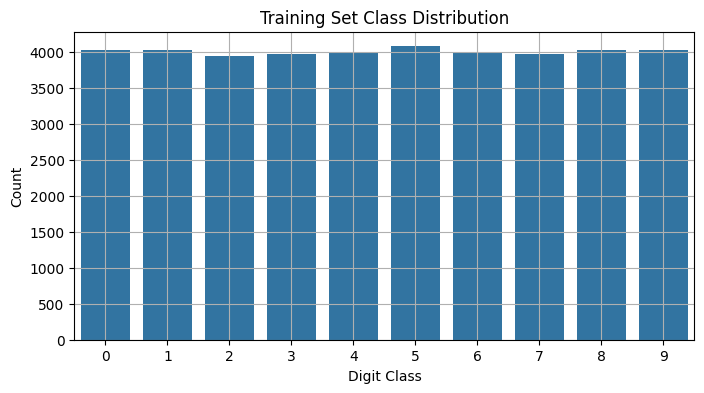

Validation label distribution: Counter({2: 1062, 7: 1040, 3: 1037, 4: 1016, 6: 1005, 9: 982, 0: 978, 1: 977, 8: 975, 5: 928})


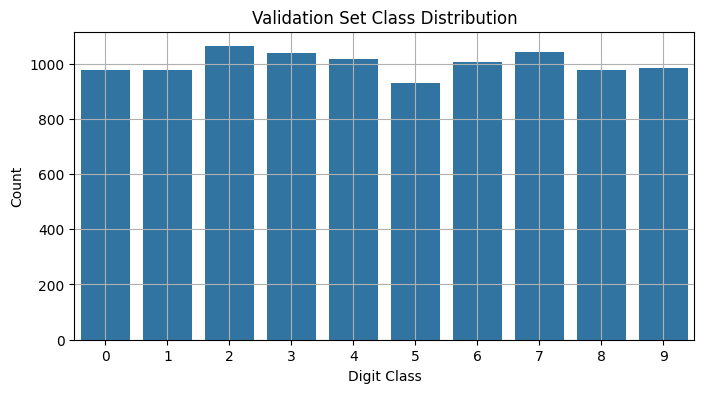

Testing label distribution: Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


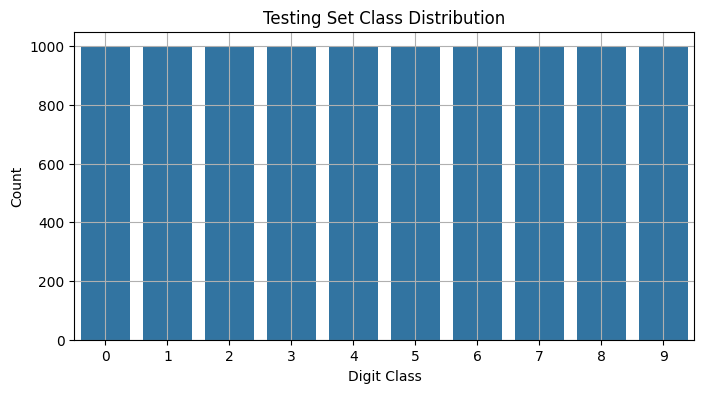

In [10]:
def plot_distribution(counter, title):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counter.keys()), y=list(counter.values()))
    plt.title(title)
    plt.xlabel("Digit Class")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# Training set

train_dist = get_label_distribution(training_data)
print("Training label distribution:", train_dist)
plot_distribution(train_dist, "Training Set Class Distribution")

# Validation set

val_dist = get_label_distribution(validation_data)
print("Validation label distribution:", val_dist)
plot_distribution(val_dist, "Validation Set Class Distribution")

# Testing set

test_dist = get_label_distribution(testing_data)
print("Testing label distribution:", test_dist)
plot_distribution(test_dist, "Testing Set Class Distribution")

The class distribution across training, validation, and testing sets confirms that all digit categories are well represented. While minor variations exist, the overall balance supports fair training and evaluation. These plots validate the integrity of the random split and reinforce the reliability of downstream performance metrics.

# Build a CNN Network

Build a CNN network with convolution layers to classify the images.

# Implement Sweep Strategy

Implement a sweep strategy to find the optimal hyperparameters to maximize accuracy.

Systematically vary key hyperparameters - kernel size, stride, batch size, and learning rate - to assess their impact on training loss, validation accuracy, and feature map evolution.  This modular sweep enables principled experimentation, helping identify optimal architecture and training settings for improved model performance and stakeholder clarity.

## Create Sweep Grid

Create a sweep grid to explore four key hyperparameters that influence CNN performance.

In [11]:
sweep_grid = {'kernel_size': [3],
              'stride': [2],
              'batch_size': [16],
              'learning_rate': [0.001]}

**Kernel size** [3, 5] tests the impact of local versus broader spatial feature extraction.

**Stride** [1, 2] assesses how spatial resolution and downsizing effect learning.

**Batch size** [32, 64] evaluates gradient stability, generalization, and training efficiency.

**Learning rate** [0.001, 0.01] measures convergence speed and sensitivity to weight updates.

This grid yields 16 unique configurations (2 * 2 * 2 * 2), each to be trained and evaluated to compare loss, accuracy, and feature map evolution.

The goal is to identify the optimal combinations for model performance.

## Compute Flattened Size Function

Function to compute the current input size for the model.  Use input shape 32 * 32 with three channels.

In [12]:
def compute_flattened_size(model, input_shape = (3, 32, 32)):
  with torch.no_grad():
    dummy = torch.zeros(1, *input_shape)
    output = model(dummy)
    return output.view(1, -1).shape[1]

This utility function dynamically computes the flattened output size of a CNN’s feature extractor, given an input shape (defaulting to a 3×32×32 CIFAR-10 image). It’s especially useful when designing the transition from convolutional layers to fully connected layers.

It's purpose is to determine the number of features output by the final convolutional layer, so that the first fully connected layer can be correctly sized.

## Create Model Builder

This function constructs a configurable CNN architecture for CIFAR-10 classification, enabling systematic variation of kernel size and stride.

In [13]:
def build_model(kernel_size, stride):
  feature_extractor = nn.Sequential(
      nn.Conv2d(3, 6, kernel_size = kernel_size, stride = stride),
      nn.ReLU(),
      nn.Conv2d(6, 16, kernel_size = kernel_size, stride = stride),
      nn.ReLU(),
      nn.Flatten()
  )

  flattened_size = compute_flattened_size(feature_extractor)

  return nn.Sequential(
      feature_extractor,
      nn.Linear(flattened_size, 10),
      nn.Softmax(dim = 1)
  )

## Create DataLoader Factory

This utility function wraps the creation of PyTorch DataLoader objects for training, validation, and testing datasets, enabling efficient and reproducible batching across sweep configurations.

In [14]:
def create_dataloaders(training_data, validation_data, testing_data, batch_size):
  training_loader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
  validation_loader = DataLoader(validation_data, batch_size = batch_size, shuffle = False)
  testing_loader = DataLoader(testing_data, batch_size = batch_size, shuffle = False)
  return training_loader, validation_loader, testing_loader

## Create Train Model Function

This function orchestrates the training and validation loop for a CNN on CIFAR-10, logging key diagnostics across epochs to support hyperparameter sweep analysis and stakeholder reporting.

### Parameters

**model**: CNN architecture returned by build_model(...).

**train_loader, val_loader**: DataLoaders for training and validation sets.

**learning_rate**: Sweep-controlled optimizer parameter.

**epochs**: Number of training epochs (default: 50).

### Training Loop

Uses Adam optimizer for adaptive learning.

Applies CrossEntropyLoss, suitable for multi-class classification.

Logs average training loss per epoch for sweep diagnostics.

### Validation Accuracy

Switches to evaluation mode to disable dropout/batchnorm.

Computes validation accuracy as a percentage of correct predictions.

### Logging Outputs

Returns two lists:

**train_loss_log**: Epoch-wise training loss.

**val_acc_log**: Epoch-wise validation accuracy.

These logs are sweep-aware and plug directly into the visualization pipeline for comparative analysis across kernel size, stride, batch size, and learning rate.

In [34]:
def train_model(model, train_loader, val_loader, learning_rate, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_log = []
    val_acc_log = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_loss_log.append(avg_train_loss)

        # Validation accuracy

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_acc_log.append(val_acc)

    return train_loss_log, val_acc_log

## Create Sweep Runner Function

This function executes a full hyperparameter sweep across kernel size, stride, batch size, and learning rate, logging training dynamics and final performance metrics for each configuration. It’s the backbone of your diagnostic workflow, enabling reproducible, interpretable experimentation.

### Parameters

**training_data, validation_data, testing_data**: Preprocessed CIFAR-10 datasets.

**sweep_grid**: Dictionary defining the hyperparameter ranges.

### Sweep Logic

For each combination of hyperparameters:

Model Construction: Builds a CNN using build_model(k, s) with specified kernel size and stride.

DataLoader Creation: Batches data using create_dataloaders(...) with the current batch size.

Training & Logging: Trains the model using train_model(...), logging:

Epoch-wise training loss

Epoch-wise validation accuracy

### Result Storage

Final training loss and validation accuracy are stored in results.

Full configuration is stored in configs.

Per-epoch logs are stored in logs.

In [33]:
def run_sweep(training_data, validation_data, testing_data, sweep_grid, epochs):
    results = []
    configs = []
    logs = []

    for k in sweep_grid["kernel_size"]:
        for s in sweep_grid["stride"]:
            for b in sweep_grid["batch_size"]:
                for lr in sweep_grid["learning_rate"]:
                    print(f"Running: kernel_size = {k}, stride = {s}, batch_size = {b}, learning_rate = {lr}")

                    # Build model

                    model = build_model(k, s)

                    # Create dataloaders

                    training_loader, validation_loader, testing_loader = create_dataloaders(
                        training_data, validation_data, testing_data, b
                    )

                    # Train model and log per-epoch metrics

                    train_loss_log, val_acc_log = train_model(
                        model, training_loader, validation_loader, lr, epochs = epochs
                    )

                    # Store final metrics

                    results.append({
                        "kernel_size": k,
                        "stride": s,
                        "batch_size": b,
                        "learning_rate": lr,
                        "final_loss": round(train_loss_log[-1], 4),
                        "val_acc": round(val_acc_log[-1], 2)
                    })

                    # Store full config and logs for plotting

                    configs.append({
                        "kernel_size": k,
                        "stride": s,
                        "batch_size": b,
                        "learning_rate": lr
                    })

                    logs.append((train_loss_log, val_acc_log))

    return results, configs, logs

## Create Preview Results Function

Display top-performing configurations for quick insight and stakeholder reporting.

In [17]:
def preview_results(results, top_n = 10):
  df = pd.DataFrame(results)
  print(df.sort_values(by = "val_acc", ascending = False).head(top_n))

# Stratified Subset Selector

Selects a specified subset of images from the training data for sweep iterations.

In [18]:
def stratified_subset(dataset, samples_per_class=400):
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    selected_indices = []
    for label, indices in class_indices.items():
        selected_indices.extend(random.sample(indices, samples_per_class))

    return Subset(dataset, selected_indices)

# Plot Training Curves



In [37]:
import matplotlib.pyplot as plt

def plot_training_curves(configs, logs, combined=False):
    if combined:
        plt.figure(figsize=(12, 4))

        # Combined Loss Plot
        plt.subplot(1, 2, 1)
        for i, (loss_log, _) in enumerate(logs):
            plt.plot(loss_log, label=f"Config {i}")
        plt.title("Training Loss (Combined)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Combined Accuracy Plot
        plt.subplot(1, 2, 2)
        for i, (_, acc_log) in enumerate(logs):
            plt.plot(acc_log, label=f"Config {i}")
        plt.title("Validation Accuracy (Combined)")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        plt.suptitle("Training Dynamics Across All Configs")
        plt.tight_layout()
        plt.show()

    else:
        for i, (loss_log, acc_log) in enumerate(logs):
            plt.figure(figsize=(12, 4))

            # Loss curve
            plt.subplot(1, 2, 1)
            plt.plot(loss_log, label=f"Config {i}")
            plt.title("Training Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()

            # Accuracy curve
            plt.subplot(1, 2, 2)
            plt.plot(acc_log, label=f"Config {i}")
            plt.title("Validation Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy (%)")
            plt.legend()

            plt.suptitle(f"Training Dynamics for Config {i}: {configs[i]}")
            plt.tight_layout()
            plt.show()

# Run Sweeps

Run three sweeps: 1) mini, 2) diagnostic, and 3) final.

## Mini Sweep

Run mini sweep with small subset for diagnostics.

In [24]:
mini_train = stratified_subset(training_data, samples_per_class=70)
mini_val = stratified_subset(validation_data, samples_per_class=15)
mini_test = stratified_subset(testing_data, samples_per_class=15)

Confirm number of records in mini sets.

In [25]:
print("Mini training set size:", len(mini_train))
print("Mini validation set size:", len(mini_val))
print("Mini test set size:", len(mini_test))

Mini training set size: 700
Mini validation set size: 150
Mini test set size: 150


Setup sweep grid for mini diagnostic.

In [28]:
mini_sweep_grid = {'kernel_size': [3, 5],
              'stride': [1, 2],
              'batch_size': [16, 32],
              'learning_rate': [0.01, 0.001, 0.005]}

Run mini sweep using 10 epochs for quick diagnostics.

In [35]:
mini_results, mini_configs, mini_logs = run_sweep(mini_train, mini_val, mini_test, mini_sweep_grid, epochs = 10)

Running: kernel_size = 3, stride = 1, batch_size = 16, learning_rate = 0.01
Running: kernel_size = 3, stride = 1, batch_size = 16, learning_rate = 0.001
Running: kernel_size = 3, stride = 1, batch_size = 16, learning_rate = 0.005
Running: kernel_size = 3, stride = 1, batch_size = 32, learning_rate = 0.01
Running: kernel_size = 3, stride = 1, batch_size = 32, learning_rate = 0.001
Running: kernel_size = 3, stride = 1, batch_size = 32, learning_rate = 0.005
Running: kernel_size = 3, stride = 2, batch_size = 16, learning_rate = 0.01
Running: kernel_size = 3, stride = 2, batch_size = 16, learning_rate = 0.001
Running: kernel_size = 3, stride = 2, batch_size = 16, learning_rate = 0.005
Running: kernel_size = 3, stride = 2, batch_size = 32, learning_rate = 0.01
Running: kernel_size = 3, stride = 2, batch_size = 32, learning_rate = 0.001
Running: kernel_size = 3, stride = 2, batch_size = 32, learning_rate = 0.005
Running: kernel_size = 5, stride = 1, batch_size = 16, learning_rate = 0.01
Runn

Preview mini sweep results.

In [36]:
preview_results(mini_results)

    kernel_size  stride  batch_size  learning_rate  final_loss  val_acc
11            3       2          32          0.005      2.1215    30.67
1             3       1          16          0.001      2.1096    30.00
10            3       2          32          0.001      2.1334    29.33
13            5       1          16          0.001      2.1150    29.33
22            5       2          32          0.001      2.1531    28.00
19            5       2          16          0.001      2.1476    27.33
7             3       2          16          0.001      2.1361    26.67
4             3       1          32          0.001      2.0882    25.33
9             3       2          32          0.010      2.2047    23.33
2             3       1          16          0.005      2.2036    22.00


# Mini Sweep Observations

The best configurations favor a smaller kernel of 3, stride 1, and batch size 16 or 32.

Learning rate 0.001 consistently outperforms 0.005 and 0.01; it looks like higher rates likely overshoot or destabilize convergence.

Stride 2 appears to hurt accuracy slightly, especially when paired with larger learning rates.

Batch size 16 edges out 32 in top configurations, suggesting better gradient signal on this mini set.

Plot mini training curves.

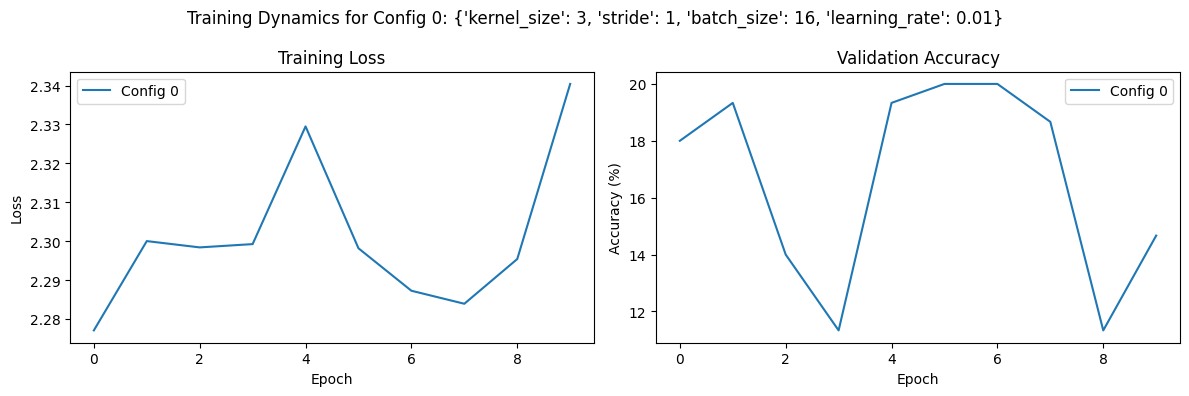

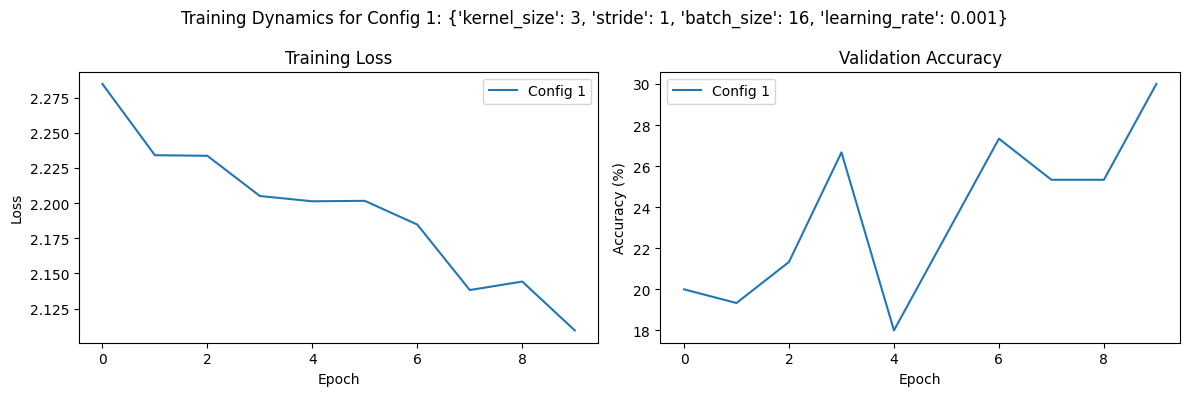

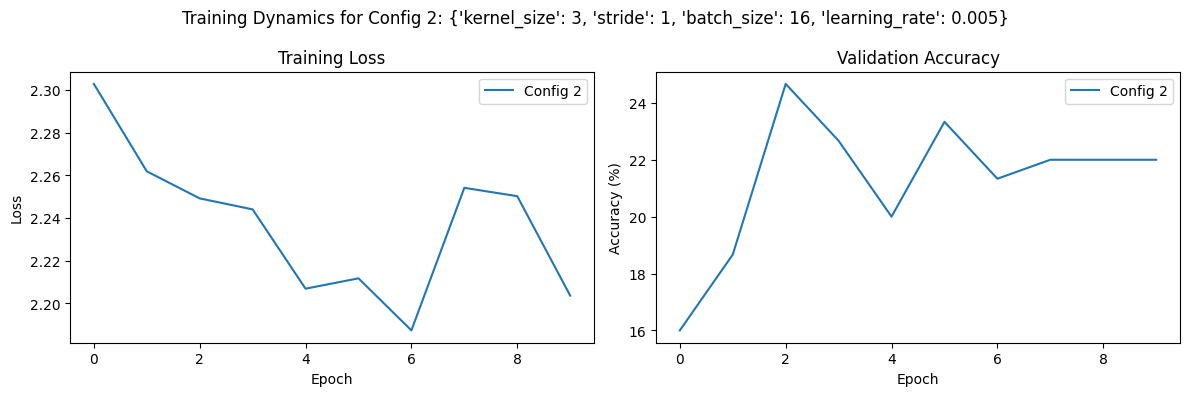

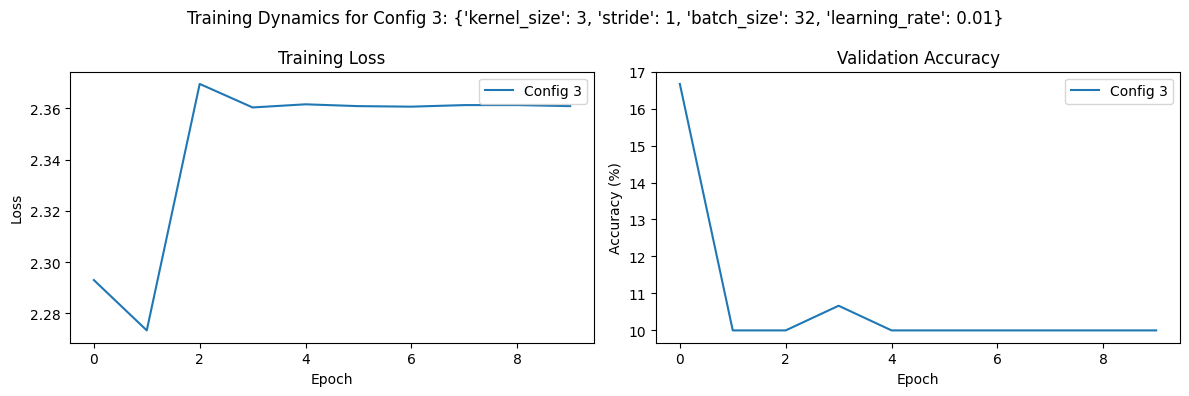

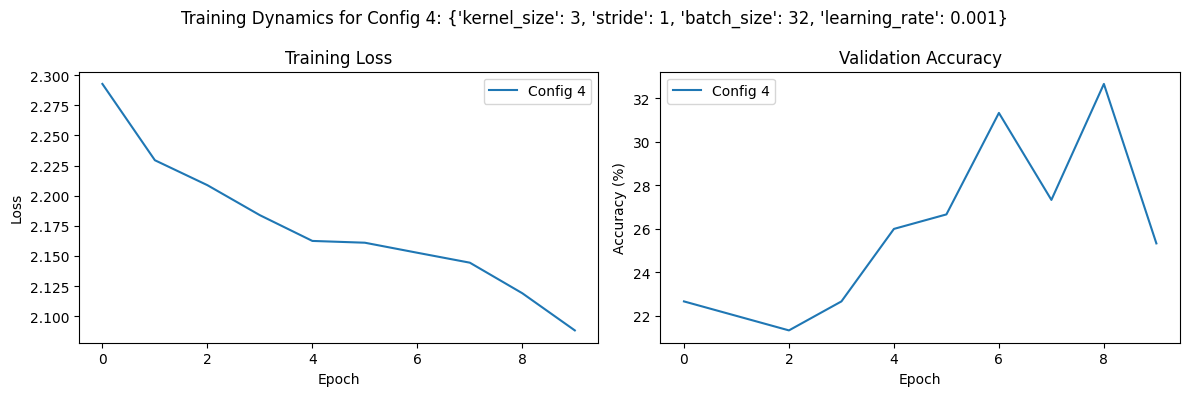

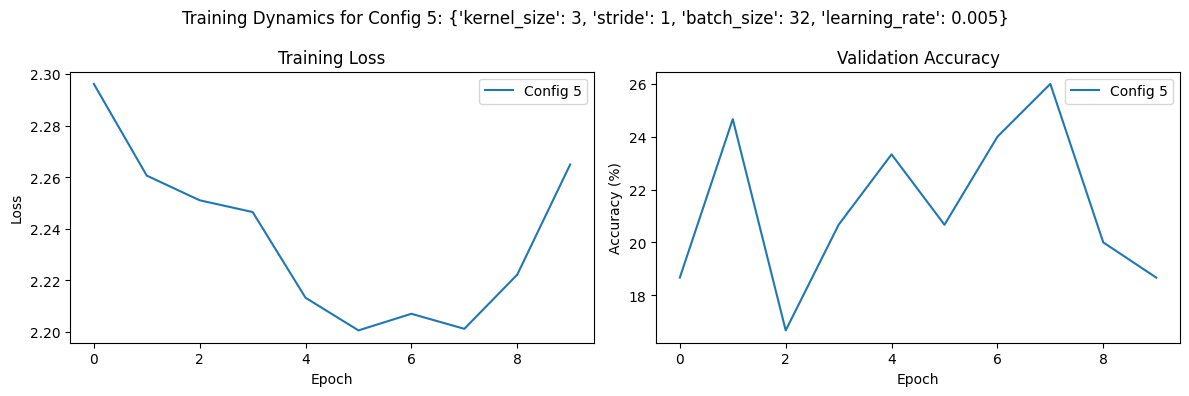

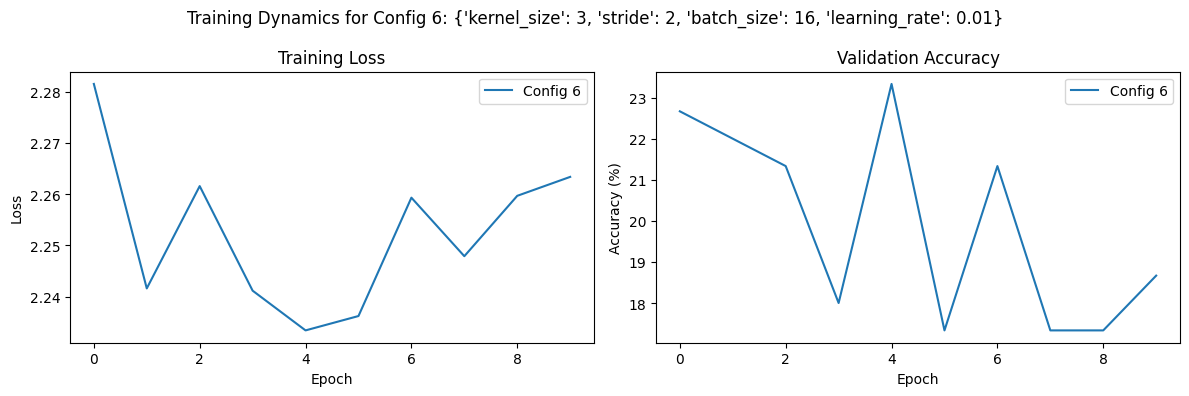

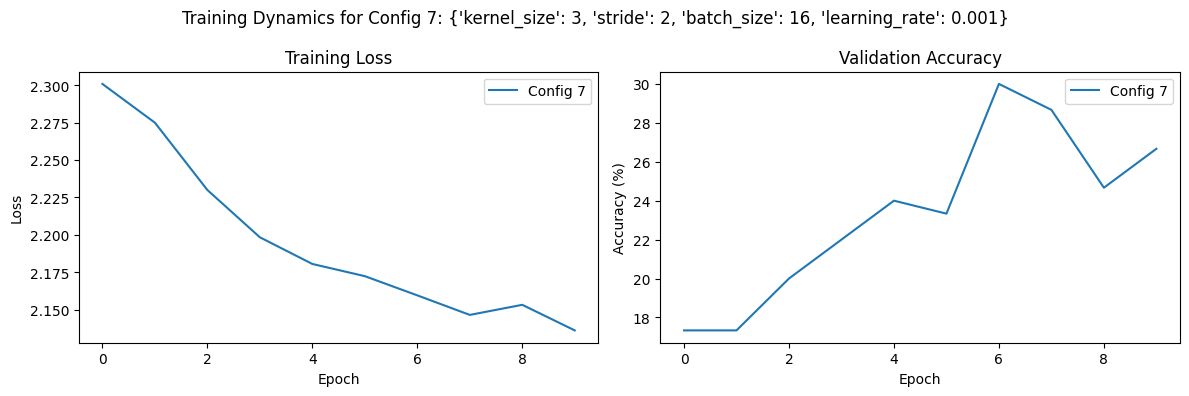

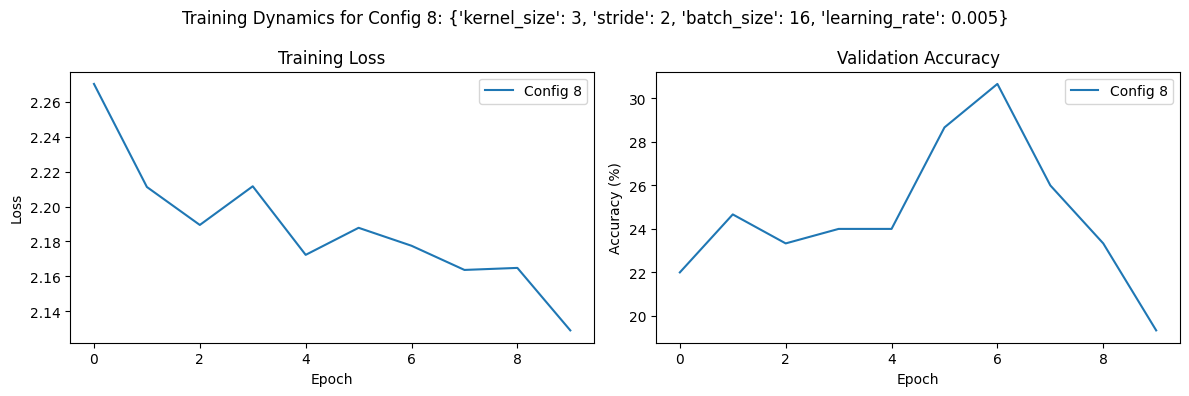

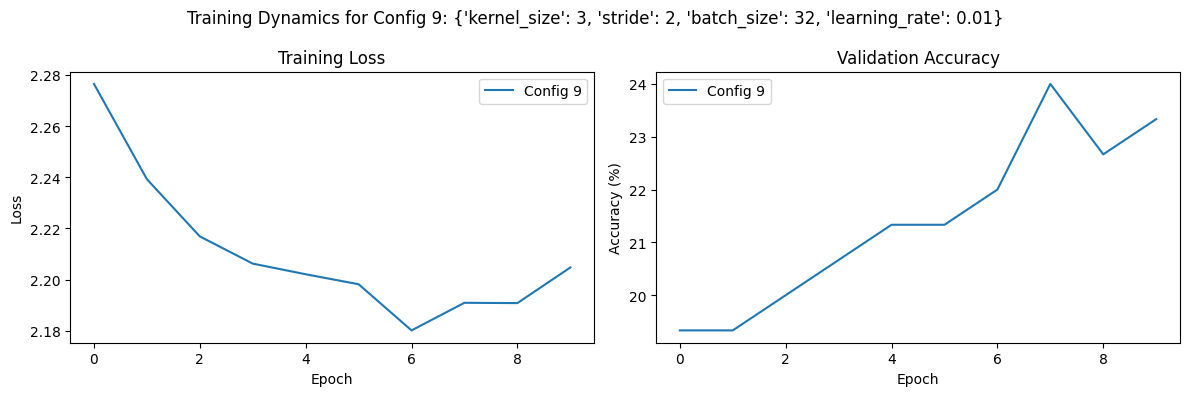

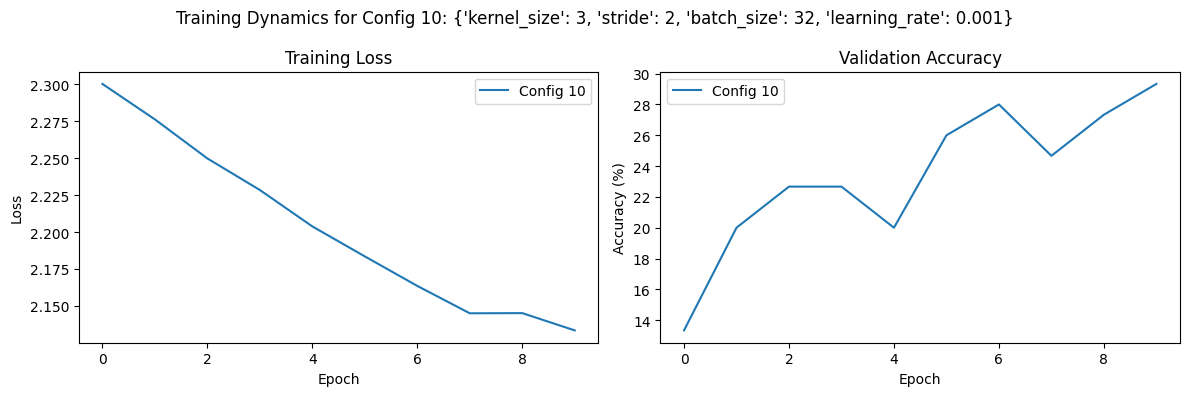

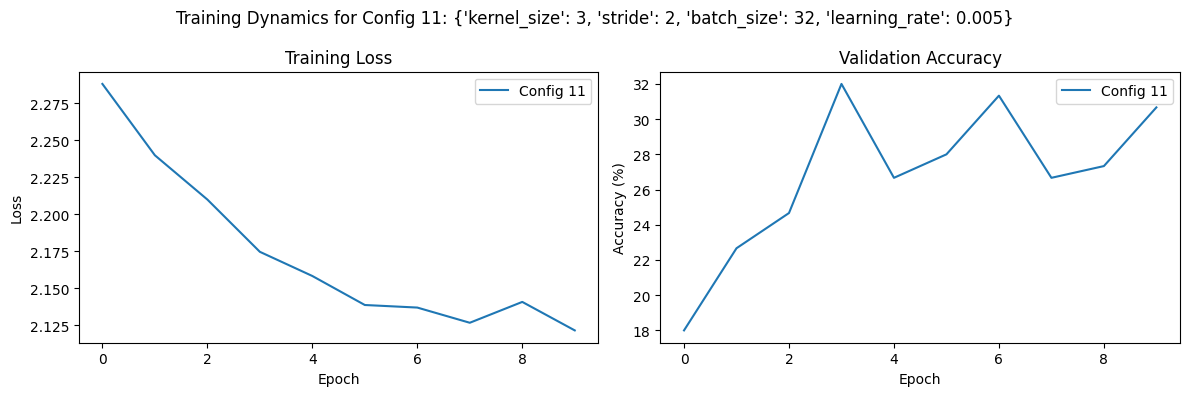

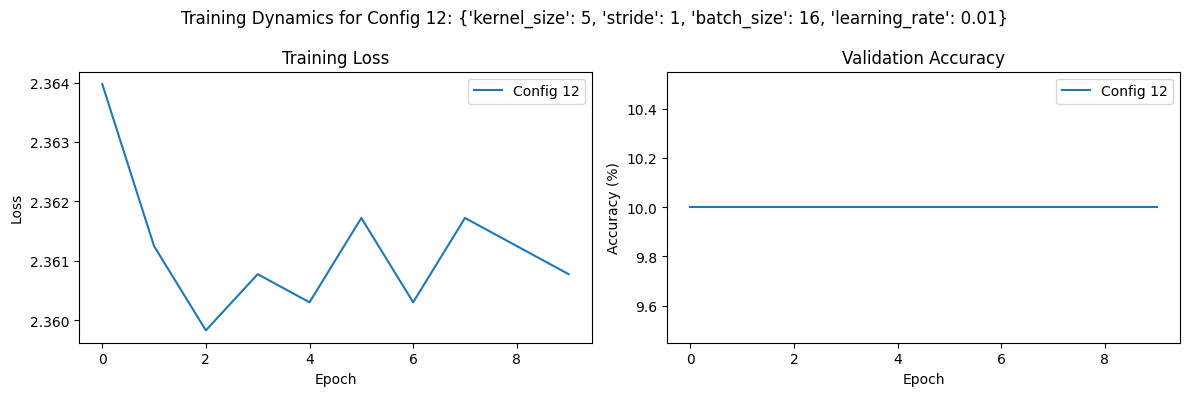

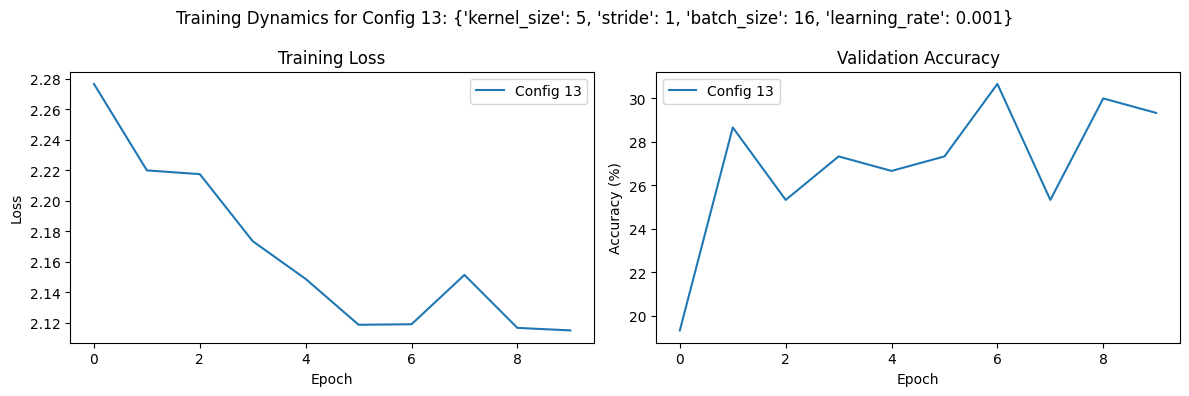

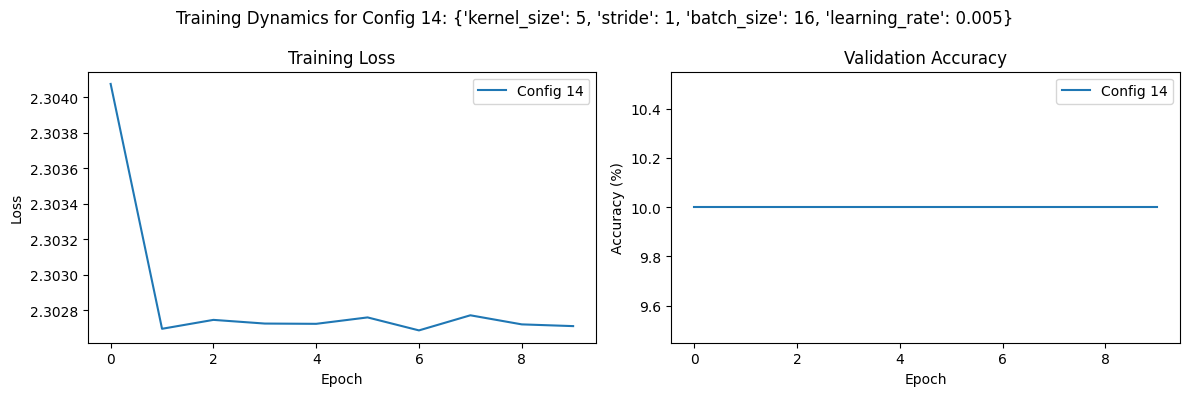

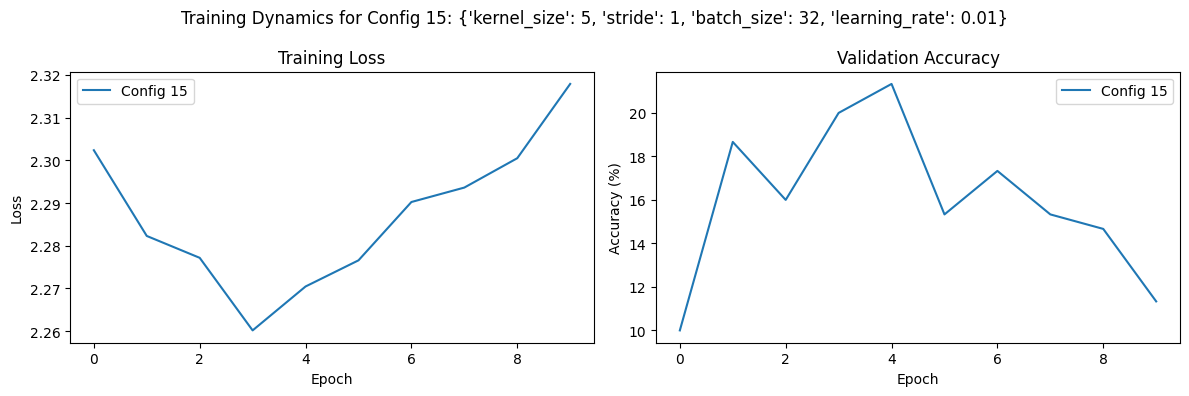

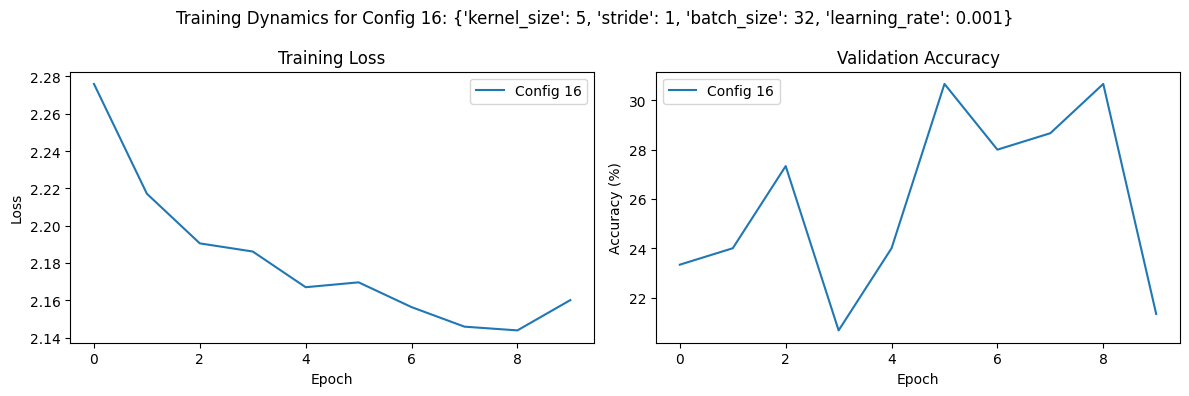

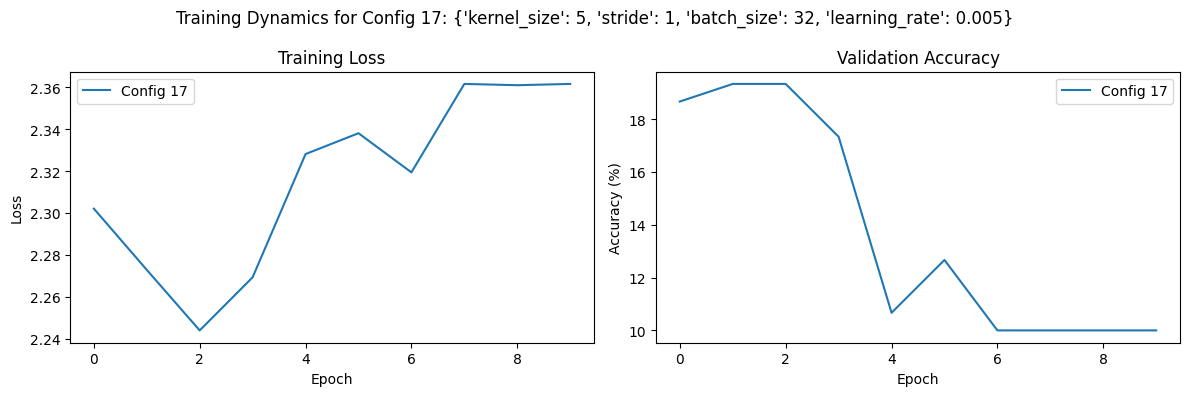

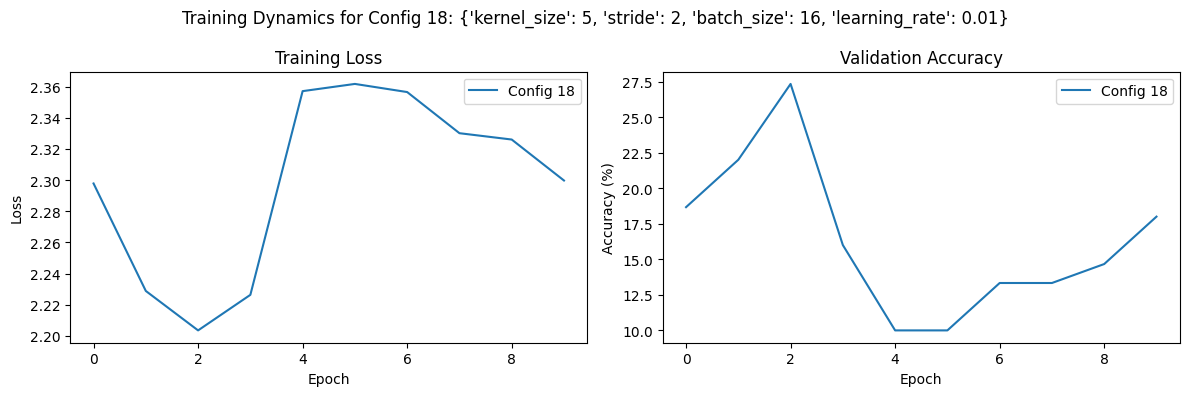

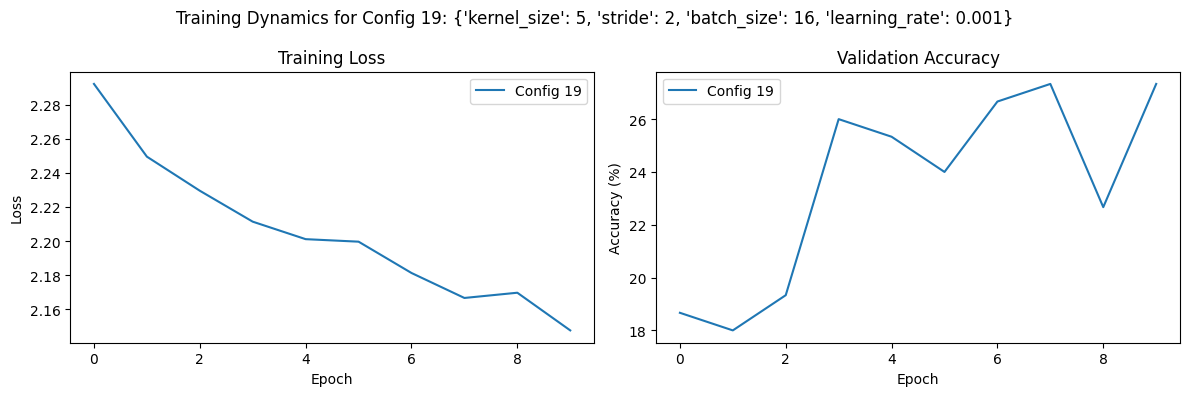

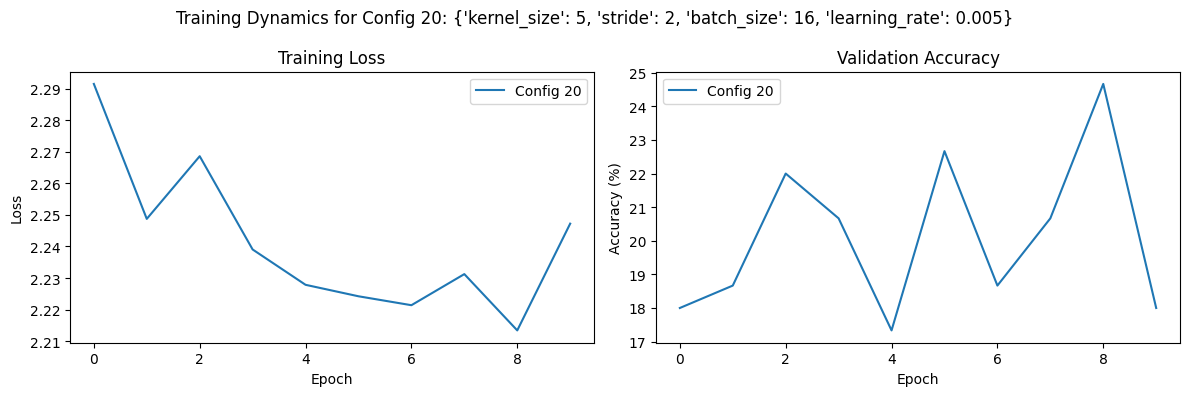

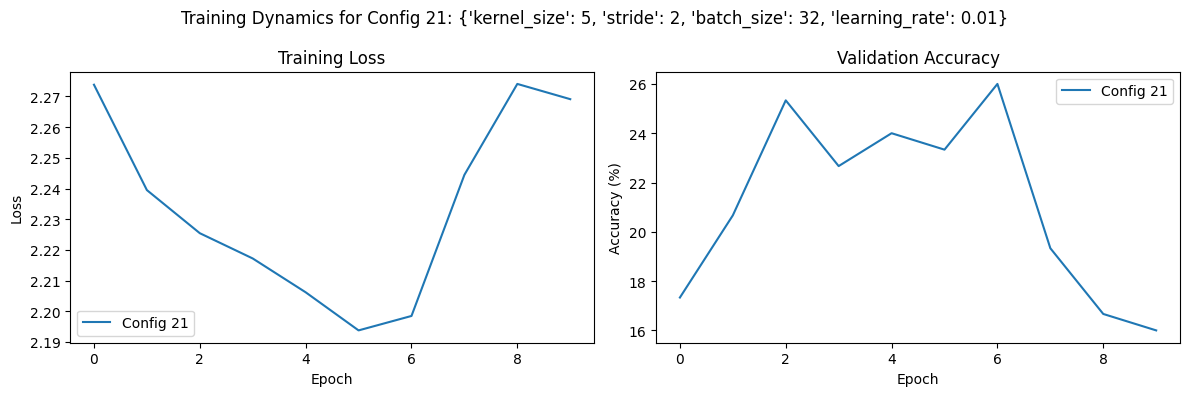

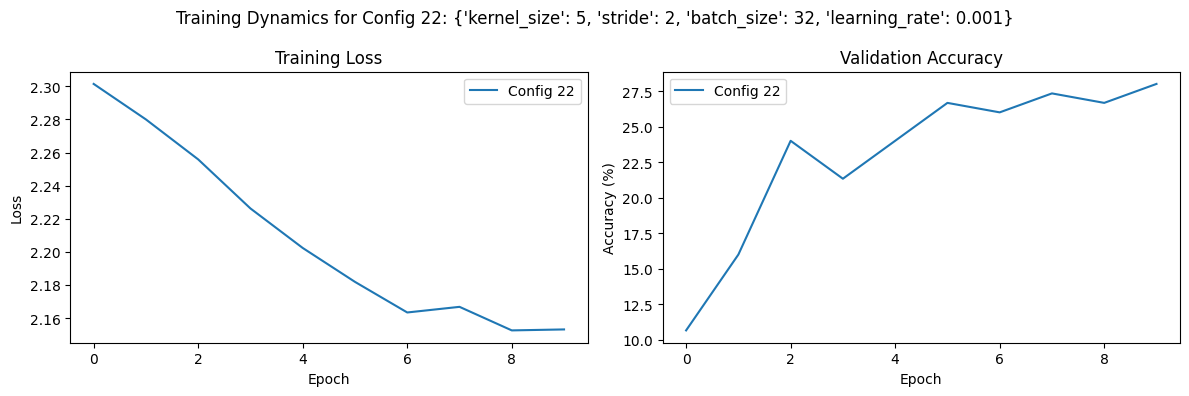

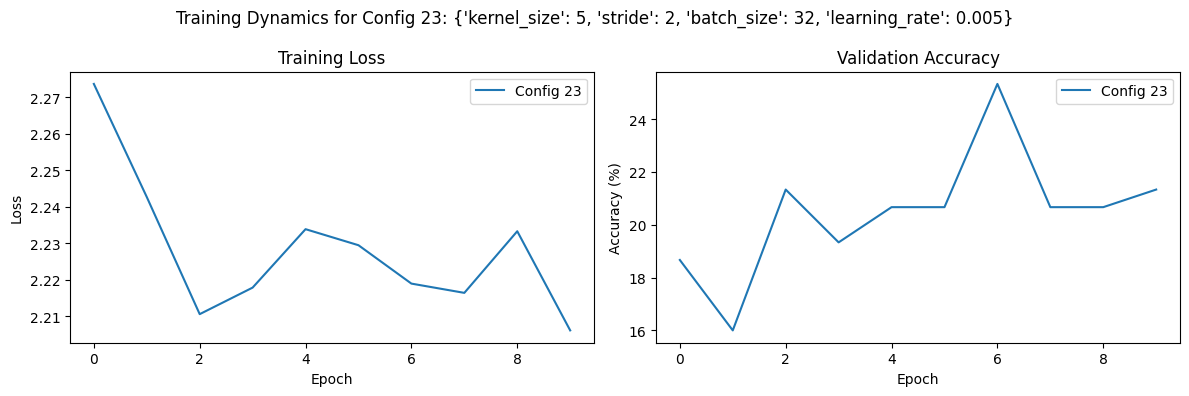

In [39]:
plot_training_curves(mini_configs, mini_logs, combined = False)

In [ ]:
results, configs, logs = run_sweep(training_data, validation_data, testing_data, sweep_grid)

Running: kernel_size = 3, stride = 2, batch_size = 16, learning_rate = 0.001


# Preview Sweep Results



In [ ]:
preview_results(results)

   kernel_size  stride  batch_size  learning_rate  final_loss  val_acc
0            3       2          16          0.001      1.9556     48.6


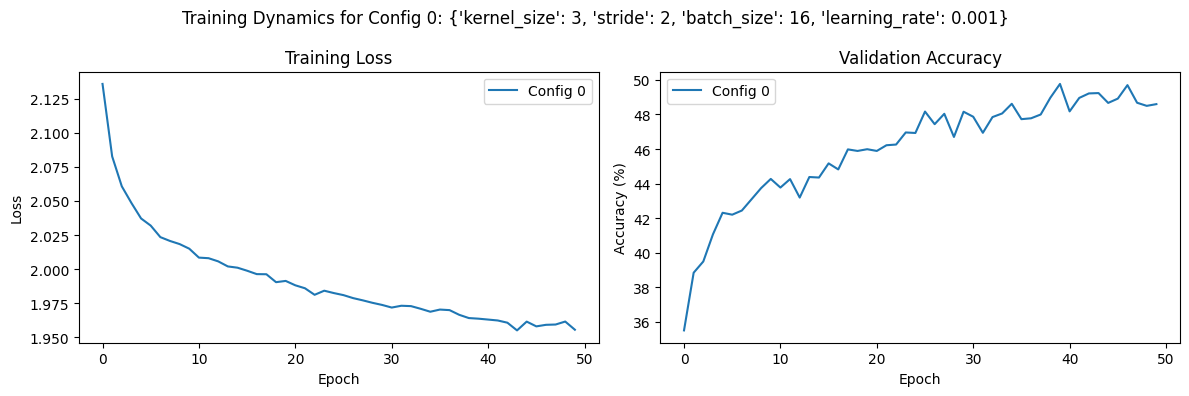

In [ ]:
plot_training_curves(configs, logs)